In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    HAVE_XGBOOST = True
except Exception:
    HAVE_XGBOOST = False

try:
    import shap
    HAVE_SHAP = True
except Exception:
    HAVE_SHAP = False

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)

In [ ]:
#Loading listings.csv and reviews.csv Data
listings = pd.read_csv('listings.csv', low_memory=False)
reviews = pd.read_csv('reviews.csv', low_memory=False)

print("Listings shape:", listings.shape)
print("Reviews shape:", reviews.shape)

Listings shape: (5298, 79)
Reviews shape: (282222, 6)


In [ ]:
# 2. Column Selection & Basic Cleaning
# Selecting useful columns

cols_keep = [
    'id', 'host_id', 'host_since', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
    'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude',
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text',
    'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_value', 'reviews_per_month'
]

# Keeping only intersection to be safe
cols_keep = [c for c in cols_keep if c in listings.columns]
listings = listings[cols_keep].copy()

# Dropping exact duplicate listing rows
listings.drop_duplicates(subset='id', inplace=True)

# Keeping rows where host_is_superhost is not missing
listings = listings[listings['host_is_superhost'].notna()].copy()

In [ ]:
# 3. Convert & normalize key columns

# Convert t/f to 1/0 for booleans (host_is_superhost, host_identity_verified)
for col in ['host_is_superhost', 'host_identity_verified']:
    if col in listings.columns:
        listings[col] = listings[col].astype(str).str.strip().replace({'t':1,'f':0}).replace({'nan':np.nan})
        listings[col] = pd.to_numeric(listings[col], errors='coerce')

# Percent strings to float for response/acceptance
for col in ['host_response_rate', 'host_acceptance_rate']:
    if col in listings.columns:
        listings[col] = listings[col].astype(str).str.replace('%','',regex=False).replace({'':np.nan}).astype(float)

# Price to float
if 'price' in listings.columns:
    listings['price'] = listings['price'].astype(str).str.replace(r'[\$,]', '', regex=True).replace({'':np.nan}).astype(float)

In [ ]:
# 4. Feature Engineering
# - host_experience_years
# - num_amenities
# - extract bathrooms numeric if necessary

# Host experience (using a fixed reference date) (set to scrape date if known)
SCRAPE_DATE = pd.to_datetime("2025-06-22")  # change if needed
if 'host_since' in listings.columns:
    listings['host_since'] = pd.to_datetime(listings['host_since'], errors='coerce')
    listings['host_experience_years'] = ((SCRAPE_DATE - listings['host_since']).dt.days / 365).fillna(0)
else:
    listings['host_experience_years'] = 0

# bathrooms: if there is a bathrooms_text field, try to extract numeric; otherwise ensure bathrooms numeric
if 'bathrooms' not in listings.columns and 'bathrooms_text' in listings.columns:
    def _extract_bath(x):
        if pd.isna(x): return np.nan
        m = re.search(r'(\d+\.?\d*)', str(x))
        return float(m.group(1)) if m else np.nan
    listings['bathrooms'] = listings['bathrooms_text'].apply(_extract_bath)

# Number of amenities (some rows are like "['Wifi', 'TV']" or strings with quotes)
if 'amenities' in listings.columns:
    listings['num_amenities'] = listings['amenities'].apply(lambda x: len(re.findall(r"'(.*?)'|\"(.*?)\"", str(x))))
else:
    listings['num_amenities'] = 0

# Fill missing for numeric engineered fields temporarily
listings['num_amenities'] = listings['num_amenities'].fillna(0)

In [ ]:
# 5. Reviews aggregation
# - review_count, avg_comment_length per listing
reviews_agg = (
    reviews.groupby('listing_id')
    .agg(
        review_count=('id', 'count'),
        avg_comment_length=('comments', lambda x: np.mean([len(str(c)) for c in x]))
    )
    .reset_index()
)

# Merge with listings
df = listings.merge(reviews_agg, left_on='id', right_on='listing_id', how='left')
df.drop(columns=['listing_id'], inplace=True, errors='ignore')

# Fill missing review aggregates
df['review_count'] = df['review_count'].fillna(0)
df['avg_comment_length'] = df['avg_comment_length'].fillna(0)

In [ ]:
# 6. Final clean numeric imputation & simple transforms

# Replace remaining empty strings in categorical fields with NaN
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].replace(['', 'nan', 'None', 'none'], np.nan)

# If listing has 0 reviews, set review_scores_* to 0 (explicitly no reviews)
review_score_cols = [c for c in df.columns if c.startswith('review_scores_')]
for c in review_score_cols:
    df.loc[df['number_of_reviews'] == 0, c] = 0

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Normalize long-tail features with log1p where appropriate
for c in ['number_of_reviews', 'review_count', 'avg_comment_length', 'host_listings_count']:
    if c in df.columns:
        df[c + '_log1p'] = np.log1p(df[c])


Superhost balance:
 host_is_superhost
1    0.537216
0    0.462784
Name: proportion, dtype: float64


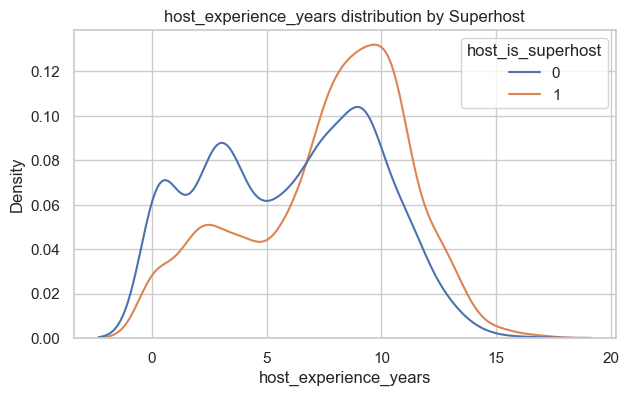

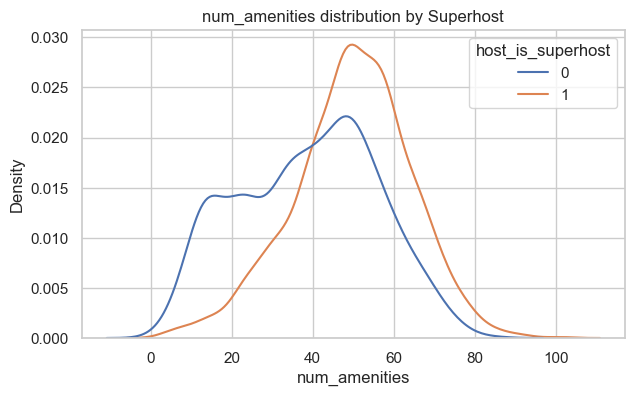

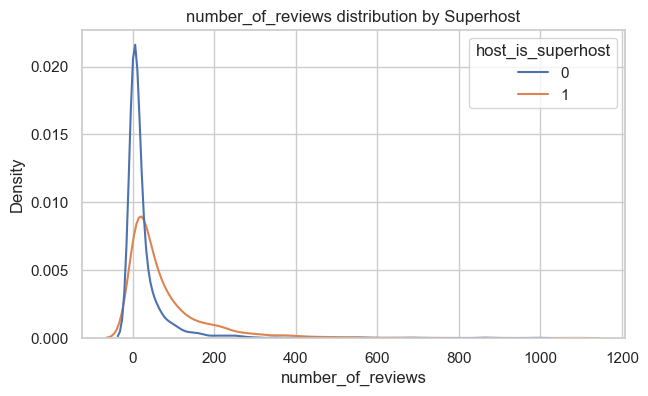

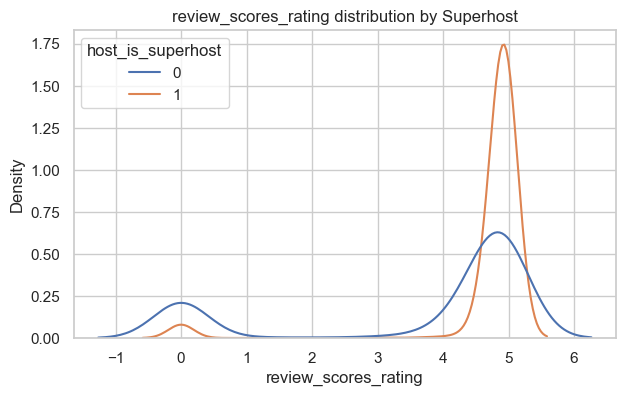

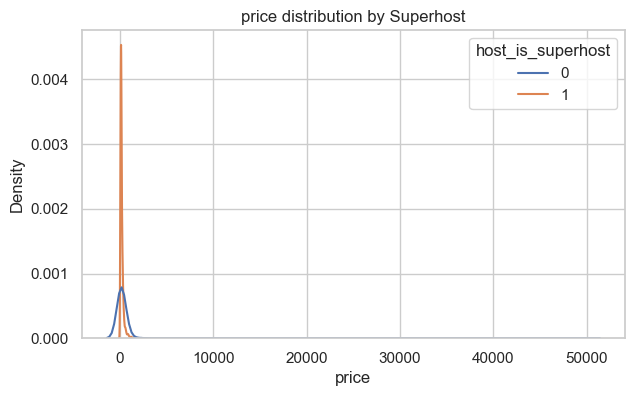

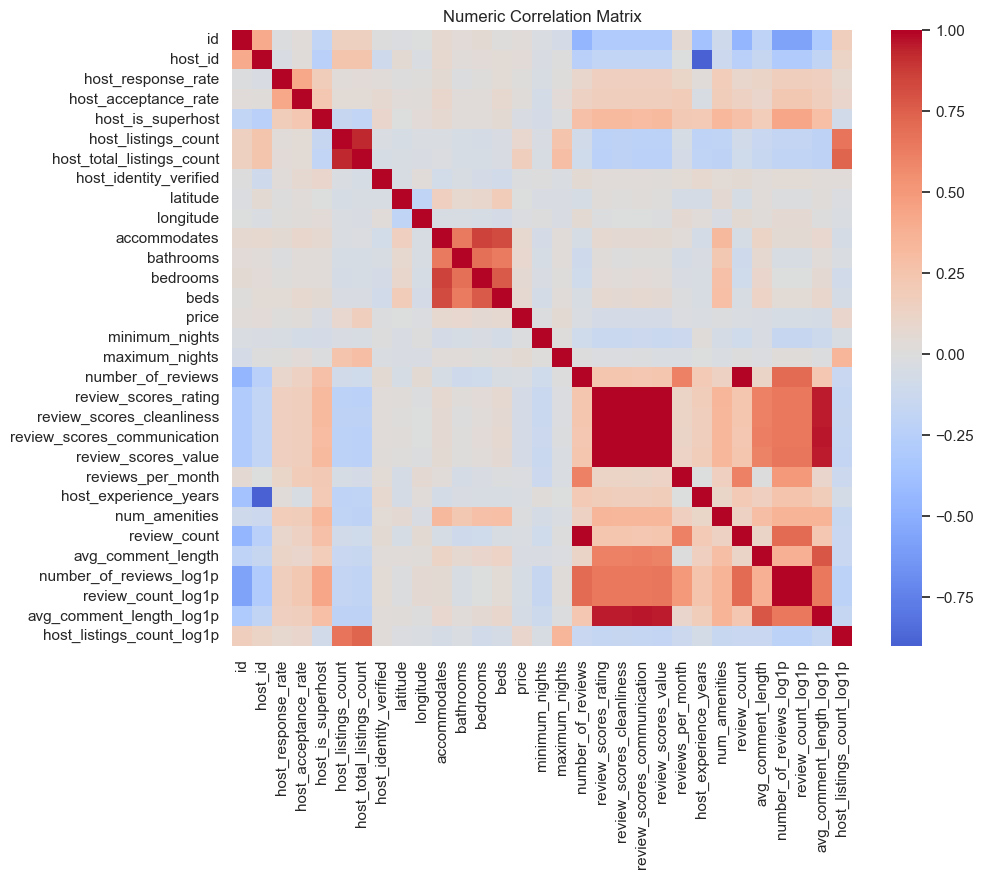

In [ ]:
# 7. EDA

# Superhost distribution
print("Superhost balance:\n", df['host_is_superhost'].value_counts(normalize=True))

# Compare numeric features by superhost status
num_features_for_plot = ['host_experience_years', 'num_amenities', 'number_of_reviews', 'review_scores_rating', 'price']
for feat in num_features_for_plot:
    if feat in df.columns:
        plt.figure(figsize=(7,4))
        sns.kdeplot(data=df, x=feat, hue='host_is_superhost', common_norm=False)
        plt.title(f"{feat} distribution by Superhost")
        plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', center=0)
plt.title("Numeric Correlation Matrix")
plt.show()


In [ ]:
# 8. Prepare for Modeling
# - target: host_is_superhost
# - drop identifier / leakage columns
TARGET = 'host_is_superhost'
DROP_COLS = [
    'id', 'host_id', 'host_since', 'amenities', 'bathrooms_text',  # id-like and raw text
    'name', 'description', 'neighborhood_overview', 'picture_url'   # if present
]
# Keep columns that actually exist
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

X = df.drop(columns=DROP_COLS + [TARGET], errors='ignore')
y = df[TARGET].astype(int)  # ensure int (0/1)

# Identify types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features[:10], "...")
print("Categorical features:", categorical_features)

Numeric features: ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms'] ...
Categorical features: ['neighbourhood_cleansed', 'property_type', 'room_type']


In [ ]:
# 9. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (4148, 31) Test shape: (1038, 31)


In [ ]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 10. Preprocessing pipeline
# - numeric: median impute + scaler
# - categorical: impute 'missing' + one-hot encode
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [ ]:
# 11. Baseline Models (Logistic Regression, Decision Tree)
# Logistic Regression pipeline
logreg = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Decision Tree pipeline
dt = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, max_depth=5))
])

# Random Forest pipeline
rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# XGBoost pipeline
if HAVE_XGBOOST:
    xgb_clf = Pipeline(steps=[
        ('preproc', preprocessor),
        ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
    ])
else:
    xgb_clf = None

models = {
    'LogisticRegression': logreg,
    'DecisionTree': dt,
    'RandomForest': rf
}
if xgb_clf:
    models['XGBoost'] = xgb_clf


Training LogisticRegression ...

-- LogisticRegression --
              precision    recall  f1-score   support

           0     0.7891    0.6937    0.7384       480
           1     0.7614    0.8405    0.7990       558

    accuracy                         0.7726      1038
   macro avg     0.7752    0.7671    0.7687      1038
weighted avg     0.7742    0.7726    0.7709      1038

ROC-AUC: 0.829596027479092


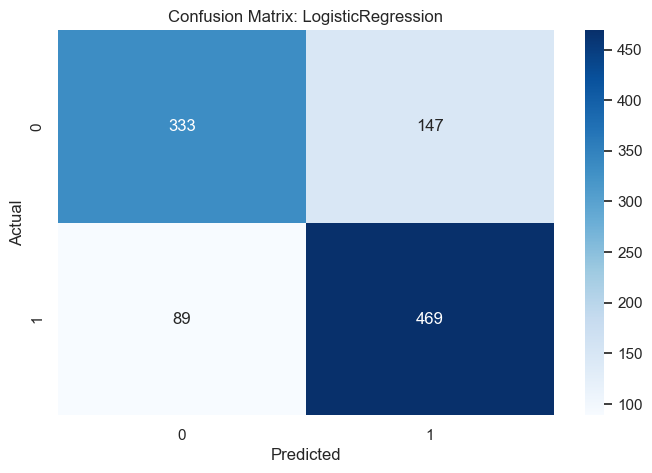

Training DecisionTree ...

-- DecisionTree --
              precision    recall  f1-score   support

           0     0.8205    0.7333    0.7745       480
           1     0.7898    0.8620    0.8243       558

    accuracy                         0.8025      1038
   macro avg     0.8052    0.7977    0.7994      1038
weighted avg     0.8040    0.8025    0.8013      1038

ROC-AUC: 0.8587682945041816


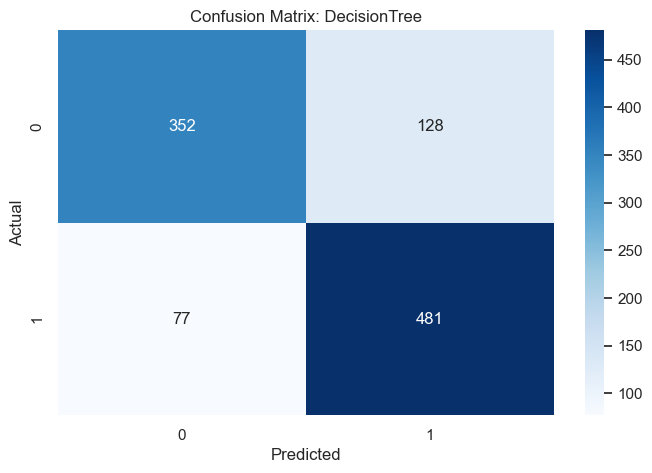

Training RandomForest ...

-- RandomForest --
              precision    recall  f1-score   support

           0     0.8358    0.8167    0.8261       480
           1     0.8453    0.8620    0.8536       558

    accuracy                         0.8410      1038
   macro avg     0.8406    0.8393    0.8399      1038
weighted avg     0.8409    0.8410    0.8409      1038

ROC-AUC: 0.9059139784946237


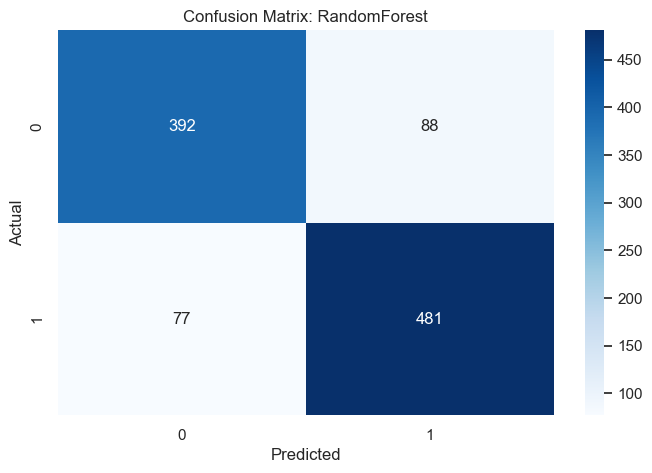

Training XGBoost ...

-- XGBoost --
              precision    recall  f1-score   support

           0     0.8675    0.8458    0.8565       480
           1     0.8702    0.8889    0.8794       558

    accuracy                         0.8690      1038
   macro avg     0.8688    0.8674    0.8680      1038
weighted avg     0.8689    0.8690    0.8688      1038

ROC-AUC: 0.9371826463560335


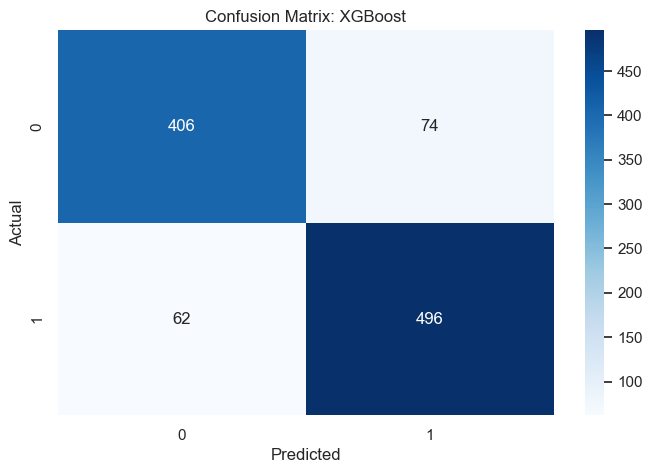

In [ ]:
# 12. Train & Evaluate (function)
def evaluate_model(pipe, X_test, y_test, name="Model"):
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    print(f"\n-- {name} --")
    print(classification_report(y_test, preds, digits=4))
    if probs is not None:
        print("ROC-AUC:", roc_auc_score(y_test, probs))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Fit and evaluate baseline models
for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test, name=name)



-- Baseline (Most Frequent) --
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       480
           1     0.5376    1.0000    0.6992       558

    accuracy                         0.5376      1038
   macro avg     0.2688    0.5000    0.3496      1038
weighted avg     0.2890    0.5376    0.3759      1038

ROC-AUC: 0.5


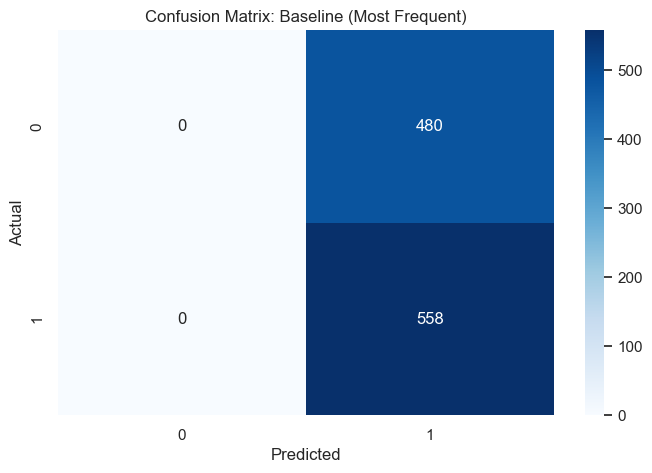

In [ ]:
# 13. Baseline comparison: Most frequent class
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
evaluate_model(dummy, X_test, y_test, name="Baseline (Most Frequent)")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__max_features': 0.2, 'clf__max_depth': None}

-- RandomForest (Tuned) --
              precision    recall  f1-score   support

           0     0.8531    0.8229    0.8378       480
           1     0.8522    0.8781    0.8650       558

    accuracy                         0.8526      1038
   macro avg     0.8527    0.8505    0.8514      1038
weighted avg     0.8526    0.8526    0.8524      1038

ROC-AUC: 0.9118036887694145


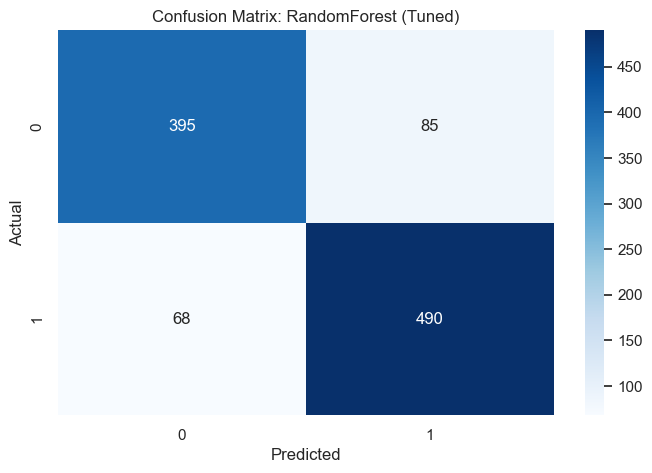

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params: {'clf__subsample': 1.0, 'clf__n_estimators': 600, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.8}

-- XGBoost (Tuned) --
              precision    recall  f1-score   support

           0     0.8774    0.8500    0.8635       480
           1     0.8743    0.8978    0.8859       558

    accuracy                         0.8757      1038
   macro avg     0.8759    0.8739    0.8747      1038
weighted avg     0.8758    0.8757    0.8756      1038

ROC-AUC: 0.9400948327359618


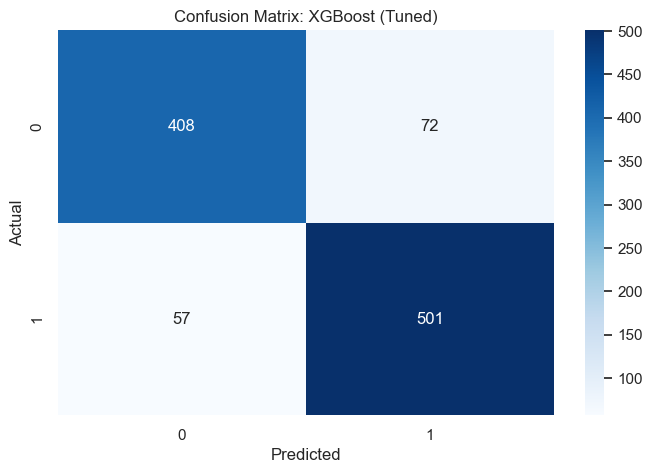

In [ ]:
# 14. Hyperparameter Tuning (RandomizedSearchCV) for Random Forest & XGBoost
# - Uses StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Randomized Search
rf_param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 6, 12, 20],
    'clf__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'clf__min_samples_split': [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=20, scoring='f1', n_jobs=-1, cv=cv, verbose=1, random_state=42
)
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
evaluate_model(best_rf, X_test, y_test, name="RandomForest (Tuned)")

# XGBoost tuning
if xgb_clf:
    xgb_param_dist = {
        'clf__n_estimators': [100, 300, 600],
        'clf__max_depth': [3,5,8],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.5, 0.8, 1.0]
    }
    xgb_search = RandomizedSearchCV(xgb_clf, xgb_param_dist, n_iter=20, scoring='f1', n_jobs=-1, cv=cv, verbose=1, random_state=42)
    xgb_search.fit(X_train, y_train)
    print("Best XGB params:", xgb_search.best_params_)
    best_xgb = xgb_search.best_estimator_
    evaluate_model(best_xgb, X_test, y_test, name="XGBoost (Tuned)")
else:
    print("XGBoost not available; skip tuning.")


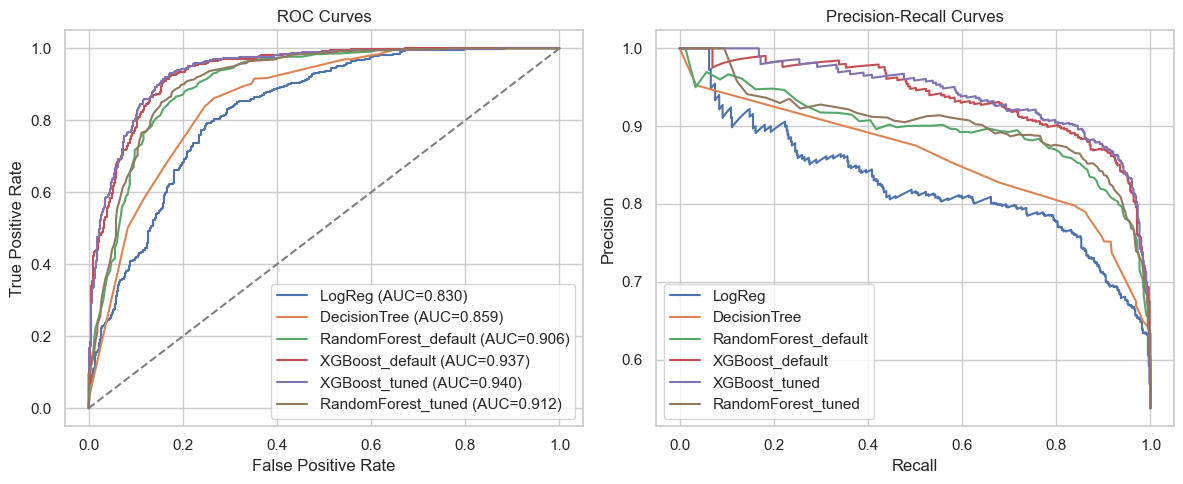

In [ ]:
# 15. Model Comparison & ROC / Precision-Recall Curves

def plot_roc_pr(models_dict, X_test, y_test):
    plt.figure(figsize=(12,5))

    # ROC Curve
    plt.subplot(1,2,1)
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, probs)
            auc_score = roc_auc_score(y_test, probs)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

    plt.plot([0,1],[0,1], '--', color='gray')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # PR Curve
    plt.subplot(1,2,2)
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:,1]
            prec, rec, _ = precision_recall_curve(y_test, probs)
            plt.plot(rec, prec, label=f"{name}")

    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Build Model Dictionary Including XGBoost

comparison_models = {
    'LogReg': logreg,
    'DecisionTree': dt,
    'RandomForest_default': rf
}

# Add Untuned XGBoost
if 'xgb_clf' in locals():
    comparison_models['XGBoost_default'] = xgb_clf

# Add Tuned XGBoost
if 'best_xgb' in locals():
    comparison_models['XGBoost_tuned'] = best_xgb

# Add Tuned Random Forest
if 'best_rf' in locals():
    comparison_models['RandomForest_tuned'] = best_rf

for name, m in comparison_models.items():
    try:
        m.predict(X_test.iloc[:1])  # will error if unfitted
    except Exception:
        m.fit(X_train, y_train)

# PLOT
plot_roc_pr(comparison_models, X_test, y_test)


=== Random Forest Feature Importance ===


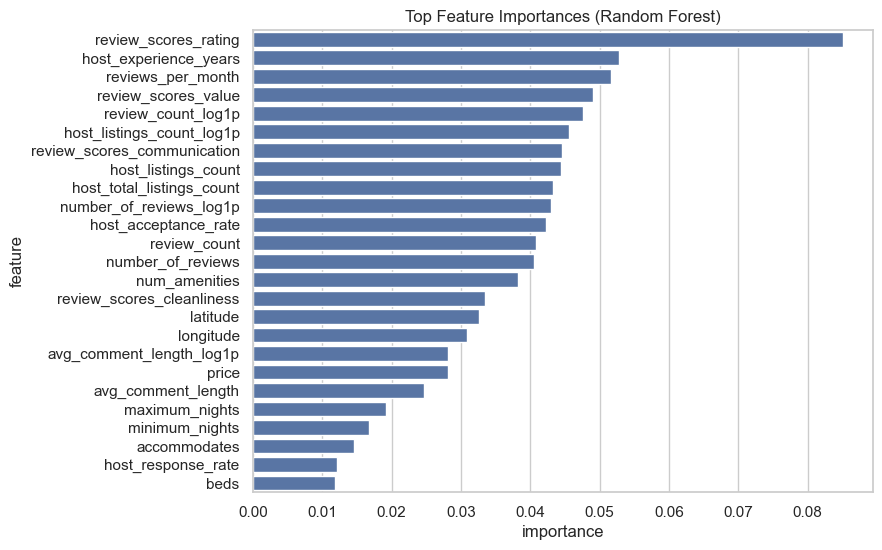


=== Logistic Regression Coefficients ===


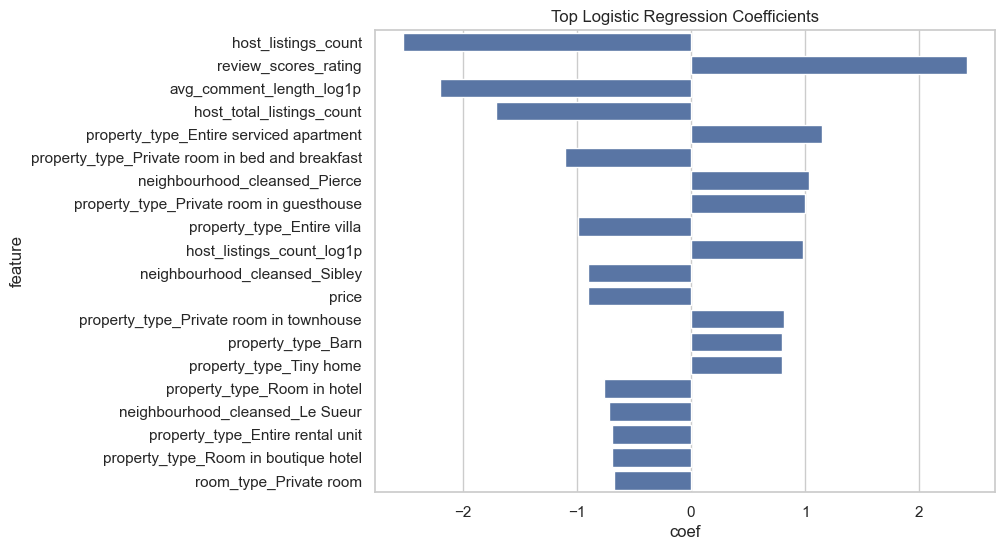

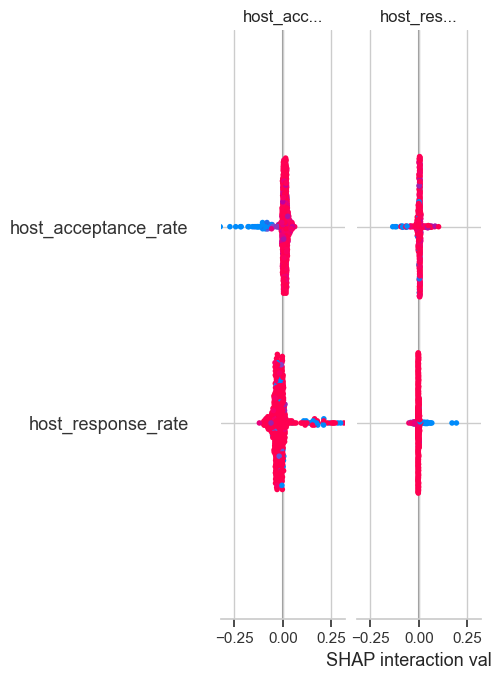

In [ ]:
# 16. Feature Importance + Interpretability

def get_feature_names(preproc, numeric_features, categorical_features):
    """Return names of all transformed features."""
    num_names = numeric_features
    ohe = preproc.named_transformers_['cat'].named_steps['ohe']
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    return num_names + cat_names


# Random Forest Feature Importance
if 'best_rf' in locals():
    print("\n=== Random Forest Feature Importance ===")

    # Use the correct step names: "preproc" and "clf"
    feat_names = get_feature_names(best_rf.named_steps['preproc'],
                                   numeric_features, categorical_features)

    importances = best_rf.named_steps['clf'].feature_importances_

    fi = (
        pd.DataFrame({'feature': feat_names, 'importance': importances})
          .sort_values('importance', ascending=False)
          .head(25)
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(x='importance', y='feature', data=fi)
    plt.title("Top Feature Importances (Random Forest)")
    plt.show()


# Logistic Regression Coefficients
try:
    print("\n=== Logistic Regression Coefficients ===")

    coef = logreg.named_steps['clf'].coef_[0]
    feat_names = get_feature_names(logreg.named_steps['preproc'],
                                   numeric_features, categorical_features)

    coef_df = pd.DataFrame({'feature': feat_names, 'coef': coef})
    coef_df['abscoef'] = coef_df['coef'].abs()

    top_coef = coef_df.sort_values('abscoef', ascending=False).head(20)

    plt.figure(figsize=(8,6))
    sns.barplot(x='coef', y='feature', data=top_coef)
    plt.title("Top Logistic Regression Coefficients")
    plt.show()

except Exception as e:
    print("Could not extract logistic coefficients:", e)


# SHAP Values
X_small = X_train.sample(500, random_state=42)
X_small_trans = best_rf.named_steps['preproc'].transform(X_small)

explainer = shap.TreeExplainer(best_rf.named_steps['clf'])

shap_values = explainer(X_small_trans)

shap.summary_plot(
    shap_values,
    X_small_trans,
    feature_names=get_feature_names(
        best_rf.named_steps['preproc'],
        numeric_features,
        categorical_features
    )
)

In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
best_rf.named_steps

{'preproc': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  ['host_response_rate', 'host_acceptance_rate',
                                   'host_listings_count',
                                   'host_total_listings_count',
                                   'host_identity_verified', 'latitude',
                                   'longitude', 'accommodates', 'bathrooms',
                                   'bedrooms', 'beds', 'price', 'minimum_nights',
                                   'maximu...
                                   'review_count', 'avg_comment_length',
                                   'number_of_reviews_log1p',
                                   'review_count_log1p',
                                   'avg_comme